In [21]:
# pip install lightgbm
# pip install fairlearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

In [22]:
df_cleaned = pd.read_csv("../data/default_clean_v1.csv", index_col=0)

# Enocde target variable
df_cleaned['default'] = df_cleaned['default'].apply(lambda y: 1 if y == 'Yes' else 0)
df_cleaned = df_cleaned.drop(columns=["default payment next month"], axis=1)
df_cleaned

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,Female,Undergraduate,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,Female,Undergraduate,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,Female,Undergraduate,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,Female,Undergraduate,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,Male,Undergraduate,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,Male,High School,Married,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,Male,High School,Single,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,Male,Undergraduate,Single,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,Male,High School,Married,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## SEX

In [23]:
# Data imbalances
print(df_cleaned['SEX'].value_counts(normalize=True))
print(df_cleaned['default'].value_counts(normalize=True))

SEX
Female    0.603209
Male      0.396791
Name: proportion, dtype: float64
default
0    0.776892
1    0.223108
Name: proportion, dtype: float64


## Load Fairness-unaware model -- XGBoost

In [24]:
# load model 1
model1 = pickle.load(open("../model/Model1.pkl", "rb"))
data1 = pickle.load(open("../model/Model1_data.pkl", "rb"))
y_test1, y_pred1, predicted_prob1, col_X_train1, X_train1, X_test1, y_train1 = data1

In [25]:
def model_perf(model, y_test, y_pred, predicted_prob, col_X_train):
    # Accuracy
    print("Accuracy: ", round(accuracy_score(y_test, y_pred),3))
    
    # Precision, Recall, and F1-Score
    print("Precision: ", round(precision_score(y_test, y_pred),3))
    print("Recall: ", round(recall_score(y_test, y_pred),3))
    print("F1: ", round(f1_score(y_test, y_pred),3))
    
    # AUC
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.values, predicted_prob, pos_label = 1)
    round(auc(false_positive_rate, true_positive_rate),3)
    
    #somers' D
    somersd=(2*auc(false_positive_rate, true_positive_rate)) - 1
    round(somersd, 3)
    
    # KS
    df=pd.DataFrame()
    df['real'] = y_test
    df['proba'] = predicted_prob
    class0 = df[df['real'] ==0 ]
    class1 = df[df['real'] ==1 ]
    ks = stats.ks_2samp(class0['proba'],class1['proba']).statistic
    p  = stats.ks_2samp(class0['proba'],class1['proba']).pvalue
    print("The KS is", round(ks,3), " (p-value:", round(p,3),")")
    
    # Importance
    importance = pd.DataFrame({'Feature':list(col_X_train),'Importance':model.feature_importances_})
    importance = importance.sort_values(by=['Importance'], ascending=False)
    print(importance)
    

In [26]:
model_perf(model1, y_test1, y_pred1, predicted_prob1, col_X_train1)

Accuracy:  0.808
Precision:  0.613
Recall:  0.368
F1:  0.46
The KS is 0.411  (p-value: 0.0 )
                    Feature  Importance
2                     PAY_0    0.329073
3                     PAY_2    0.094201
4                     PAY_3    0.053195
5                     PAY_4    0.034384
7                     PAY_6    0.034025
6                     PAY_5    0.027029
16                 PAY_AMT3    0.022980
8                 BILL_AMT1    0.022753
0                 LIMIT_BAL    0.022329
23    EDUCATION_High School    0.022170
19                 PAY_AMT6    0.021801
17                 PAY_AMT4    0.021532
15                 PAY_AMT2    0.020758
10                BILL_AMT3    0.020616
12                BILL_AMT5    0.020494
14                 PAY_AMT1    0.020239
13                BILL_AMT6    0.019729
9                 BILL_AMT2    0.019527
18                 PAY_AMT5    0.019091
22       EDUCATION_Graduate    0.018841
26         MARRIAGE_Married    0.018675
11                BILL_AMT4

## Fairness assessment of unmitigated model
There are three main steps we want to perform:
1. Identify who will be harmed.
2. Identify the types of harms we anticipate.
3. Define fairness metrics based on the anticipated harms.

In [27]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

In [28]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

In [ ]:
# Convert the one-hot encoding back to one column of sex
def determine_sex(row):
    if row['SEX_Female']:
        return 'female'
    elif row['SEX_Male']:
        return 'male'

# Apply the function to create the 'SEX' column
X_test1['SEX'] = X_test1.apply(determine_sex, axis=1)

In [36]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test1,
    y_pred=y_pred1,
    sensitive_features=X_test1['SEX'],
)

metricframe_unmitigated.by_group[metrics_to_report]

metricframe_unmitigated.difference()[metrics_to_report]

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.650855
false_positive_rate    0.066445
false_negative_rate    0.631846
dtype: float64

In [37]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

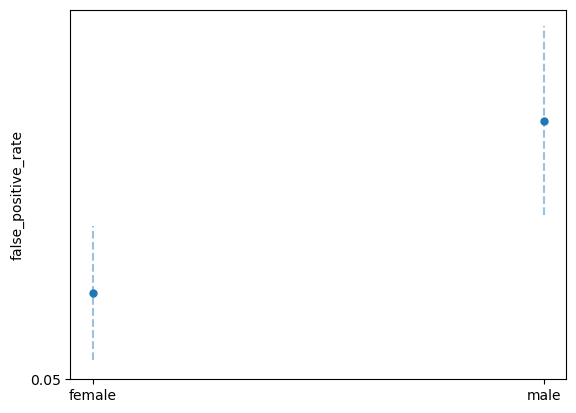

In [38]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

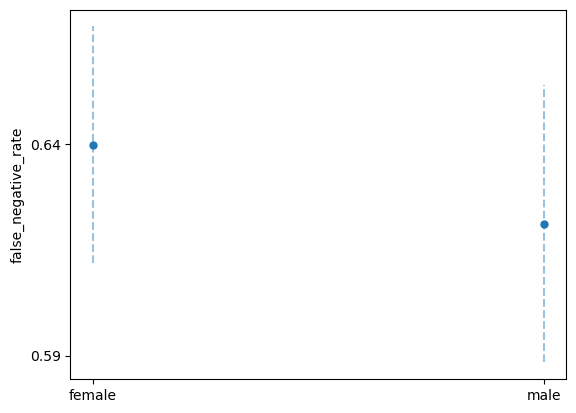

In [39]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

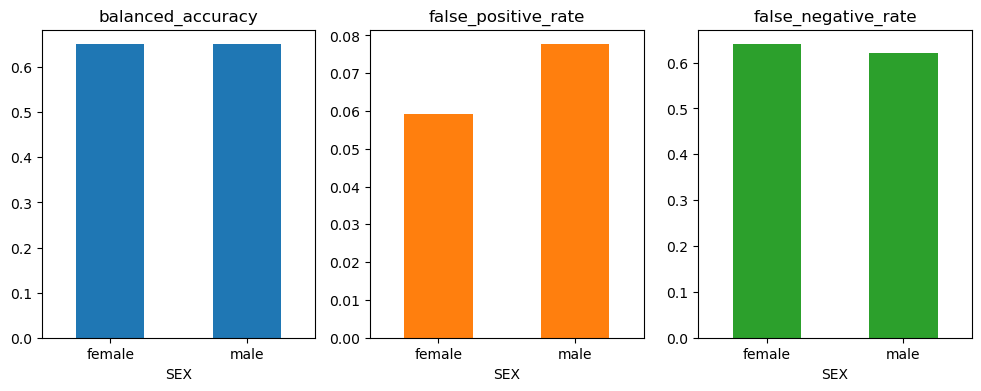

In [40]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

In [47]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test1, y_pred1)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test1, y_pred1, sensitive_features=X_test1['SEX']
)
equalized_odds_unmitigated

0.018682866331742765